# PyLCM

In [25]:
#import necessary modules
from PyLCM.animation import *
from PyLCM.widget import *
from PyLCM.timestep_routine import *
#import user modifiable modules
from Post_process.analysis import *
from Post_process.print_plot import *

# uncomment lines below when changing source files
#######################
%load_ext autoreload
%autoreload 2
#######################

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intialization
## Input parameter

### Model steering parameters

In [26]:
dt_widget, nt_widget, Condensation_widget, Collision_widget, n_particles_widget, max_z_widget = model_steering_input()

'Model steering parameters'

BoundedFloatText(value=0.5, description='dt [s]:', max=5.0, min=0.0001, style=DescriptionStyle(description_wid…

IntText(value=3600, description='nt:', style=DescriptionStyle(description_width='initial'))

Checkbox(value=True, description='Condensation:', style=DescriptionStyle(description_width='initial'))

Checkbox(value=False, description='Collision:', style=DescriptionStyle(description_width='initial'))

BoundedIntText(value=500, description='n_particles:', max=1000, min=100, style=DescriptionStyle(description_wi…

BoundedFloatText(value=1500.0, description='z_max [m]:', max=2000.0, step=0.1, style=DescriptionStyle(descript…

### Parcel parameters

In [27]:
T_widget, P_widget, RH_widget, w_widget, z_widget = parcel_info_input()

ascending_mode_widget = ascending_mode_input()

'Parcel initial parameters: '

BoundedFloatText(value=293.2, description='T [K]:', max=320.0, min=200.0, step=0.1, style=DescriptionStyle(des…

BoundedFloatText(value=101300.0, description='P [Pa]:', max=105000.0, min=95000.0, step=1.0, style=Description…

BoundedFloatText(value=0.88, description='RH [-]:', max=0.99, min=0.01, step=0.01, style=DescriptionStyle(desc…

BoundedFloatText(value=0.5, description='w [m/s]:', max=10.0, step=0.1, style=DescriptionStyle(description_wid…

BoundedFloatText(value=0.0, description='z [m]:', max=20000.0, step=100.0, style=DescriptionStyle(description_…

ToggleButtons(description='Mode', layout=Layout(width='max-content'), options=('linear', 'sine', 'in_cloud_osc…

### Aerosol parameters

In [84]:
# choose the mode for aerosol initialization
mode_aero_init_widget = aero_mode_input()
# Initialization parameters for aerosol (up to 4 modes)
gridwidget = grid_modes_input()

#use activation radius with kohler critical radius
kohler_activation_radius = False

'Aerosol initialisation mode: '

ToggleButtons(layout=Layout(width='max-content'), options=('weighting_factor', 'random'), value='weighting_fac…

N_aero: number of aerosols per cubic centimeter, mu: mean droplet radius, sigma: std of mu


GridspecLayout(children=(Button(button_style='info', description='Mode #1 (plot)', layout=Layout(grid_area='wi…

# Time step routine

In [76]:
# setting of display mode while running: either output of variables in text form (fast, recommended) = 'text'
# or: continuously updated plot using plotly (slow, time & memory consuming) = 'graphics'
mode_displaytype_widget = timestep_display_mode_settings()

'Display mode: '

ToggleButtons(index=1, layout=Layout(width='max-content'), options=('text_fast', 'graphics'), value='graphics'…

In [ ]:
nt, dt, time_array, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, \
qa_ts,qc_ts,qr_ts, na_ts,nc_ts,nr_ts, \
spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts = timesteps_function(n_particles_widget, P_widget, \
                                 RH_widget, T_widget, w_widget, nt_widget, \
                                 dt_widget, rm_spec, ascending_mode_widget, \
                                 mode_displaytype_widget, z_widget, max_z_widget, \
                                 Condensation_widget, Collision_widget, \
                                 mode_aero_init_widget, gridwidget, kohler_activation_radius)

# post processing and analysis
## plots
plots can be drawn either as time-series or as vertical profiles

In [109]:
# user can choice if he wants the plots time-dependent or height-dependent (except of DSD and particle densities always being time dependent)
mode_plots_widget, increment_widget = plot_widgets_settings(nt)

ToggleButtons(description='Plots are:', layout=Layout(width='max-content'), options=('time-series', 'vertical …

'For droplet spectra: set increment (e.g. 20: every 20th timestep a line is drawn): '

BoundedIntText(value=20, description='For droplet spectra: increment: ', max=900, min=1, style=DescriptionStyl…

/project/meteo/work/J.Lim/PyLCM_parcel/Post_process/print_plot.py:25: UserWarning:

Log scale: values of z <= 0 have been masked



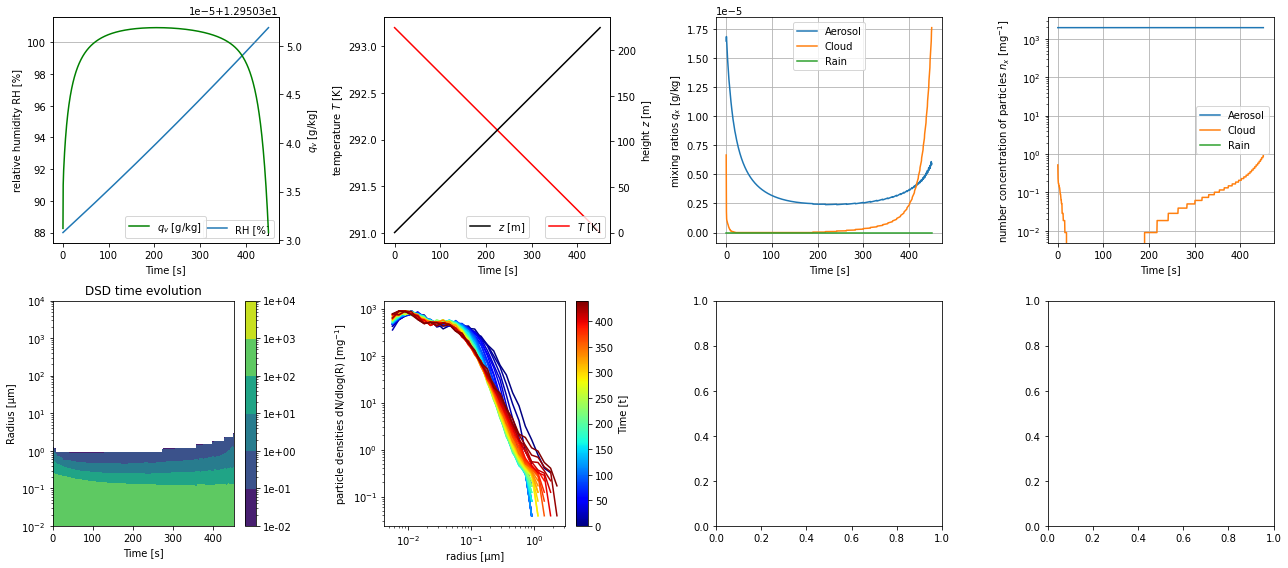

In [112]:
plot_mode=mode_plots_widget.value
subplot_array_function(plot_mode, dt, nt,rm_spec, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, spectra_arr, increment_widget)

## data output
options for saving output variables and drop size spectra, files will be written in the subfolder 'output'

In [189]:
#file_name  = 

In [190]:
# save array of output variables into csv-file, optional filename can be given as filename='my_filename.csv'
save_model_output_variables(time_array, RH_parcel_array, q_parcel_array, T_parcel_array, z_parcel_array, qa_ts, \
                            qc_ts, qr_ts, na_ts, nc_ts, nr_ts, filename='testoutput_model_230809.csv')

Output data written to: output/testoutput_model_230809.csv


In [191]:
# save array of DSD spectra per timesteps, combined with radii to csv-file
save_model_output_dsd(spectra_arr, rm_spec, rl_spec, rr_spec, nt, filename='dsd_array_output_test_230822.csv')

Output data of droplet size distribution written to: output/dsd_array_output_test_230822.csv
